In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import math
from matplotlib import pyplot as plt
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')
%config InlineBackend.figure_format = 'retina'
sns.set(style="ticks")
plt.rc('figure', figsize=(6, 3.7), dpi=100)
plt.rc('axes', labelpad=20, facecolor="#ffffff", 
       linewidth=0.4, grid=True, labelsize=10)
plt.rc('patch', linewidth=0)
plt.rc('xtick.major', width=0.2)
plt.rc('ytick.major', width=0.2)
plt.rc('grid', color='#EEEEEE', linewidth=0.25)
plt.rc('font', family='Arial', weight='400', size=10)
plt.rc('text', color='#282828')
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
plt.rc('savefig', pad_inches=0.3, dpi=300)


# Load the training dataset
data = pd.read_csv('/Users/danielaquinteronarvaez/Library/CloudStorage/GoogleDrive-d.quinterona@student.uw.edu.pl/My Drive/UW/II-Semester/Machine Learning/Project/data/newborn_train.csv')

# Configuring float numbers format to 2 decimal points
pd.options.display.float_format = '{:20.2f}'.format
data.head(n=5)

,mother_body_mass_index,mother_marital_status,mother_delivery_weight,mother_race,mother_height,mother_weight_gain,father_age,father_education,cigarettes_before_pregnancy,prenatal_care_month,number_prenatal_visits,previous_cesarean,newborn_gender,newborn_weight
0,30.80,2.00,220.00,1,65.00,35.00,29.00,6,0.00,2,10.00,N,F,3045
1,45.80,NaN,293.00,1,64.00,26.00,37.00,4,0.00,3,10.00,N,F,3061
2,NaN,1.00,NaN,1,66.00,NaN,33.00,6,0.00,3,NaN,N,F,3827
3,24.30,1.00,157.00,1,NaN,20.00,27.00,6,0.00,3,9.00,N,M,3997
4,24.10,1.00,187.00,1,65.00,42.00,29.00,8,0.00,2,12.00,N,F,3240


In [2]:
# Statistical information about the dataset

#numerical data
data.describe(include=[np.number], percentiles=[.80]) \
    .transpose().drop("count", axis=1)

,mean,std,min,50%,80%,max
mother_body_mass_index,27.17,6.76,13.00,25.70,32.10,69.80
mother_marital_status,1.40,0.49,1.00,1.00,2.00,2.00
mother_delivery_weight,188.32,41.37,100.00,181.00,219.00,400.00
mother_race,1.52,1.11,1.00,1.00,2.00,6.00
mother_height,64.12,2.84,30.00,64.00,66.00,78.00
mother_weight_gain,29.48,15.15,0.00,29.00,41.00,98.00
father_age,31.80,6.81,11.00,31.00,37.00,98.00
father_education,4.90,2.31,1.00,4.00,7.00,9.00
cigarettes_before_pregnancy,1.10,4.73,0.00,0.00,0.00,98.00
prenatal_care_month,5.30,15.06,0.00,3.00,4.00,99.00


In [3]:
# categorical data
data.describe(include=[np.object]).transpose() \
    .drop("count", axis=1)

,unique,top,freq
previous_cesarean,3,N,2020874
newborn_gender,2,M,1225891


### Data cleaning:
1. Remove unncessary rows and store clean data in new variable
2. Encode categorical variables
3. Handle missing values
4. Remove outliers

In [4]:
###### BMI function to calculte missing bmi, height, weight

# bmi, height, weight function
def calculate_missing_value(weight_lb, height_in, bmi):
    if pd.isnull(weight_lb):
        # Calculate weight in pounds
        calculated_weight_lb = bmi * (height_in ** 2) / 703
        return calculated_weight_lb
    elif pd.isnull(height_in):
        # Calculate height in inches
        calculated_height_in = math.sqrt((weight_lb / bmi) * 703)
        return calculated_height_in
    elif pd.isnull(bmi):
        # Calculate BMI
        calculated_bmi = (weight_lb / (height_in ** 2)) * 703
        return calculated_bmi
    else:
        # No missing value
        return None

In [5]:
# For the training dataset (1/4)

# removing unnecessary columns with no influence in the weight of the baby

# Drop mother_marital_status
data_clean = data.drop('mother_marital_status', axis=1)

# Encode categorical variables
cesarean_mapping = {'N': 1, 'Y': 2, 'U': 3}  #later we will one hot encode
data_clean['previous_cesarean'] = data['previous_cesarean'].map(cesarean_mapping)

gender_mapping = {'F': 0, 'M': 1}
data_clean['newborn_gender'] = data['newborn_gender'].map(gender_mapping)

## Missing values

# Getting the number of missing values in each column
num_missing = data_clean.isna().sum()
# Excluding columns that contains 0 missing values
num_missing = num_missing[num_missing > 0]
# Getting the percentages of missing values
percent_missing = num_missing * 100 / data_clean.shape[0]
# Concatenating the number and perecentage of missing values 
# into one dataframe and sorting it
pd.concat([num_missing, percent_missing], axis=1, 
          keys=['Missing Values', 'Percentage']).\
          sort_values(by="Missing Values", ascending=False)

,Missing Values,Percentage
father_age,444506,18.54
mother_height,244529,10.20
mother_body_mass_index,146600,6.11
mother_weight_gain,73473,3.06
number_prenatal_visits,59901,2.50
mother_delivery_weight,34958,1.46
cigarettes_before_pregnancy,11301,0.47


In [6]:
### Dealing with the missing values (2/4)

#### father_age ==> Impute using KNN

    # Create a new DataFrame with the relevant columns for imputation
to_impute = data_clean[['father_age', 'father_education', 'newborn_weight']]

    # Split the data into two subsets: one with complete data and another with missing values
complete_FA = to_impute.dropna()
missing_FA = to_impute[to_impute['father_age'].isnull()]

    # Perform K-nearest neighbors (KNN) imputation on the missing values
knn_imputer = KNNImputer(n_neighbors=5)
imputed_FA = knn_imputer.fit_transform(complete_FA)

    # Convert the imputed data back into a DataFrame
imputed_FA = pd.DataFrame(imputed_FA, columns=complete_FA.columns)

    # Assign the imputed values to the 'father_age' column in the original DataFrame
data_clean.loc[missing_FA.index, 'father_age'] = imputed_FA['father_age']

    ## remaining values set to 36 (median between 50% and 90% of observ)
data_clean['father_age'] = data_clean['father_age'].fillna(36)

#### removing unnecessary columns with no influence in the weight of the baby
#### Drop father_education
data_clean = data_clean.drop('father_education', axis=1)

#### mother_height 

# Filter the DataFrame to select the relevant rows
# Iterate over the filtered rows and calculate missing values

filtered_data = data_clean.dropna(subset=['mother_delivery_weight', 'mother_weight_gain', 'mother_body_mass_index'])
filtered_data = filtered_data[filtered_data['mother_height'].isnull()]
for i, row in filtered_data.iterrows():
    weight_lb = row['mother_delivery_weight'] - row['mother_weight_gain']
    height_in = np.nan
    bmi = row['mother_body_mass_index']
    data_clean.at[i, 'mother_height'] = calculate_missing_value(weight_lb, height_in, bmi)

    
#### mother_body_mass_index

filtered_dataBMI = data_clean.dropna(subset=['mother_delivery_weight', 'mother_weight_gain', 'mother_height'])
filtered_dataBMI = filtered_dataBMI[filtered_dataBMI['mother_body_mass_index'].isnull()]
for i, row in filtered_dataBMI.iterrows():
    weight_lb = row['mother_delivery_weight'] - row['mother_weight_gain']
    height_in = row['mother_height']
    bmi = np.nan
    data_clean.at[i, 'mother_body_mass_index'] = calculate_missing_value(weight_lb, height_in, bmi)
    
#### mother_weight_gain

# calculate the weight before the pregnancy

# take the rows only with NA in mother_weight_gain but full data on BMI and height
filtered_dataW = data_clean.dropna(subset=['mother_delivery_weight', 'mother_body_mass_index', 'mother_height'])
filtered_dataW = filtered_dataW[filtered_dataW['mother_weight_gain'].isnull()]
for i, row in filtered_dataW.iterrows():
    weight_lb = np.nan # Calculate weight before pregnancy
    height_in = row['mother_height']
    bmi = row['mother_body_mass_index']
    
    # Use the calculate_missing_value function
    calculated_weight_before = calculate_missing_value(weight_lb, height_in, bmi)
    calculated_gain = row['mother_delivery_weight']- calculated_weight_before
    
    # Assign the calculated value to the missing row
    data_clean.at[i, 'mother_weight_gain'] = calculated_gain

# Impute missing columns of mother_weight_gain based on mother_weight_gain, mother_delivery_weight, mother_height, 
# mother_race, newborn_gender, newborn_weight

impute_data = data_clean[['mother_weight_gain', 'mother_delivery_weight', 'mother_height', 'mother_race', 'newborn_gender', 'newborn_weight']]
complete_data = impute_data.dropna()
missing_mwg = impute_data[impute_data['mother_weight_gain'].isnull()]
knn_imputer = KNNImputer(n_neighbors=5)
imputed_data = knn_imputer.fit_transform(complete_data)
imputed_data = pd.DataFrame(imputed_data, columns=complete_data.columns)
data_clean.loc[missing_mwg.index, 'mother_weight_gain'] = imputed_data['mother_weight_gain']

# impute again using only race and weight of the baby (mother_weight_gain)

impute_data2 = data_clean[['mother_weight_gain', 'mother_race', 'newborn_gender', 'newborn_weight']]
complete_data2 = impute_data2.dropna()
missing_mwg2 = impute_data2[impute_data2['mother_weight_gain'].isnull()]
knn_imputer = KNNImputer(n_neighbors=5)
imputed_data2 = knn_imputer.fit_transform(complete_data2)
imputed_data2 = pd.DataFrame(imputed_data2, columns=complete_data2.columns)
data_clean.loc[missing_mwg2.index, 'mother_weight_gain'] = imputed_data2['mother_weight_gain']

# Calculate the average value of mother_weight_gain
averageMWG = data_clean['mother_weight_gain'].mean()

# Fill missing values with the average value
data_clean['mother_weight_gain'].fillna(averageMWG, inplace=True)



#### More than 80% of the value are 0, so we impute 0 to cigarettes

data_clean['cigarettes_before_pregnancy'] = data_clean['cigarettes_before_pregnancy'].fillna(0)



### Results after imputation, checking NAs:
num_missing = data_clean.isna().sum()
num_missing = num_missing[num_missing > 0]
percent_missing = num_missing * 100 / data_clean.shape[0]
pd.concat([num_missing, percent_missing], axis=1, 
          keys=['Missing Values', 'Percentage']).\
          sort_values(by="Missing Values", ascending=False)


,Missing Values,Percentage
mother_body_mass_index,63437,2.65
number_prenatal_visits,59901,2.50
mother_delivery_weight,34958,1.46
mother_height,27418,1.14


In [7]:
# Dealing with remaining missing values (3/4)
# thought BMI calculation or imputation KNN

# with mother_height and mother_weight_gain we can find out the delivery_weight
# take the rows only with NA in mother_weight_gain but full data on BMI and height
filtered_dataW = data_clean.dropna(subset=['mother_weight_gain', 'mother_body_mass_index', 'mother_height'])
filtered_dataW = filtered_dataW[filtered_dataW['mother_delivery_weight'].isnull()]
for i, row in filtered_dataW.iterrows():
    weight_lb = np.nan # Calculate weight before pregnancy
    height_in = row['mother_height']
    bmi = row['mother_body_mass_index']
    
    # Use the calculate_missing_value function
    calculated_weight_before = calculate_missing_value(weight_lb, height_in, bmi)
    calculated_delivery_weight = calculated_weight_before + row['mother_weight_gain']
    
    # Assign the calculated value to the missing row
    data_clean.at[i, 'mother_delivery_weight'] = calculated_delivery_weight
    

# Impute remaining mother_delivery weight
impute_delweight = data_clean[['mother_delivery_weight', 'mother_weight_gain', 'mother_race', 'newborn_gender', 'newborn_weight']]
complete_data3 = impute_delweight.dropna()
missing_mdw = impute_delweight[impute_delweight['mother_delivery_weight'].isnull()]
knn_imputer = KNNImputer(n_neighbors=5)
imputed_mdw = knn_imputer.fit_transform(complete_data3)
imputed_mdw = pd.DataFrame(imputed_mdw, columns=complete_data3.columns)
data_clean.loc[missing_mdw.index, 'mother_delivery_weight'] = imputed_mdw['mother_delivery_weight']

# Calculate the average value of mother_delivery_weight
averageMDW = data_clean['mother_delivery_weight'].mean()

# Fill missing values with the average value
data_clean['mother_delivery_weight'].fillna(averageMDW, inplace=True)

# calculate BMI once more

#### mother_body_mass_index

filtered_dataBMI = data_clean.dropna(subset=['mother_delivery_weight', 'mother_weight_gain', 'mother_height'])
filtered_dataBMI = filtered_dataBMI[filtered_dataBMI['mother_body_mass_index'].isnull()]
for i, row in filtered_dataBMI.iterrows():
    weight_lb = row['mother_delivery_weight'] - row['mother_weight_gain']
    height_in = row['mother_height']
    bmi = np.nan
    data_clean.at[i, 'mother_body_mass_index'] = calculate_missing_value(weight_lb, height_in, bmi)

#### mother_height
# calculate height once more
filtered_data = data_clean.dropna(subset=['mother_delivery_weight', 'mother_weight_gain', 'mother_body_mass_index'])
filtered_data = filtered_data[filtered_data['mother_height'].isnull()]
for i, row in filtered_data.iterrows():
    weight_lb = row['mother_delivery_weight'] - row['mother_weight_gain']
    height_in = np.nan
    bmi = row['mother_body_mass_index']
    data_clean.at[i, 'mother_height'] = calculate_missing_value(weight_lb, height_in, bmi)

### checking if NAs:
num_missing = data_clean.isna().sum()
num_missing = num_missing[num_missing > 0]
percent_missing = num_missing * 100 / data_clean.shape[0]
pd.concat([num_missing, percent_missing], axis=1, 
          keys=['Missing Values', 'Percentage']).\
          sort_values(by="Missing Values", ascending=False)    

,Missing Values,Percentage
number_prenatal_visits,59901,2.50
mother_body_mass_index,25152,1.05
mother_height,25152,1.05


In [8]:
# Last iterations/imputations (4/4)
# impute BMI based on mother_delivery_weight, mother_weight_gain, newborn_gender, newborn_weight

impute_data = data_clean[['mother_weight_gain', 'mother_delivery_weight', 'mother_body_mass_index', 'mother_race', 'newborn_gender', 'newborn_weight']]
complete_data = impute_data.dropna()
missing_data = impute_data[impute_data['mother_body_mass_index'].isnull()]
knn_imputer = KNNImputer(n_neighbors=5)
imputed_data = knn_imputer.fit_transform(complete_data)
imputed_data = pd.DataFrame(imputed_data, columns=complete_data.columns)
data_clean.loc[missing_data.index, 'mother_body_mass_index'] = imputed_data['mother_body_mass_index']

# calculate height once more
filtered_data = data_clean.dropna(subset=['mother_delivery_weight', 'mother_weight_gain', 'mother_body_mass_index'])
filtered_data = filtered_data[filtered_data['mother_height'].isnull()]
for i, row in filtered_data.iterrows():
    weight_lb = row['mother_delivery_weight'] - row['mother_weight_gain']
    height_in = np.nan
    bmi = row['mother_body_mass_index']
    data_clean.at[i, 'mother_height'] = calculate_missing_value(weight_lb, height_in, bmi)
    

# 80% women are 66 height. 
# We will input these value and calculate missing BMI
data_clean['mother_height'] = data_clean['mother_height'].fillna(66)

# calculate BMI once more
#### mother_body_mass_index

filtered_dataBMI = data_clean.dropna(subset=['mother_delivery_weight', 'mother_weight_gain', 'mother_height'])
filtered_dataBMI = filtered_dataBMI[filtered_dataBMI['mother_body_mass_index'].isnull()]
for i, row in filtered_dataBMI.iterrows():
    weight_lb = row['mother_delivery_weight'] - row['mother_weight_gain']
    height_in = row['mother_height']
    bmi = np.nan
    data_clean.at[i, 'mother_body_mass_index'] = calculate_missing_value(weight_lb, height_in, bmi)


# Group the data by prenatal_care_month and calculate the average number of prenatal visits
average_visits = data_clean.groupby('prenatal_care_month')['number_prenatal_visits'].mean()
# Round down the average visits and convert to whole numbers
average_visits = average_visits.apply(math.floor)
# Fill the missing values with the corresponding average based on prenatal_care_month
data_clean['number_prenatal_visits'] = data_clean['number_prenatal_visits'].fillna(data_clean['prenatal_care_month'].map(average_visits))

### checking if NAs:
num_missing = data_clean.isna().sum()
num_missing = num_missing[num_missing > 0]
percent_missing = num_missing * 100 / data_clean.shape[0]
pd.concat([num_missing, percent_missing], axis=1, 
          keys=['Missing Values', 'Percentage']).\
          sort_values(by="Missing Values", ascending=False)

,Missing Values,Percentage


In [9]:
# Now for Test dataset
# Load the training dataset
data2 = pd.read_csv('/Users/danielaquinteronarvaez/Library/CloudStorage/GoogleDrive-d.quinterona@student.uw.edu.pl/My Drive/UW/II-Semester/Machine Learning/Project/data/newborn_test.csv')


In [10]:
# Apply cleaning and transformation:
# Configuring float numbers format to 2 decimal points
pd.options.display.float_format = '{:20.2f}'.format
# removing unnecessary columns with no influence in the weight of the baby

# Drop mother_marital_status
data2_clean = data2.drop('mother_marital_status', axis=1)

# Encode categorical variables
cesarean_mapping = {'N': 1, 'Y': 2, 'U': 3}  #later we will one hot encode
data2_clean['previous_cesarean'] = data2['previous_cesarean'].map(cesarean_mapping)

gender_mapping = {'F': 0, 'M': 1}
data2_clean['newborn_gender'] = data2['newborn_gender'].map(gender_mapping)

## Missing values

# Getting the number of missing values in each column
num_missing = data2_clean.isna().sum()
# Excluding columns that contains 0 missing values
num_missing = num_missing[num_missing > 0]
# Getting the percentages of missing values
percent_missing = num_missing * 100 / data2_clean.shape[0]
# Concatenating the number and perecentage of missing values 
# into one dataframe and sorting it
pd.concat([num_missing, percent_missing], axis=1, 
          keys=['Missing Values', 'Percentage']).\
          sort_values(by="Missing Values", ascending=False)



,Missing Values,Percentage
father_age,110518,18.43
mother_height,61559,10.27
mother_body_mass_index,36791,6.14
mother_weight_gain,18334,3.06
number_prenatal_visits,14985,2.50
mother_delivery_weight,8644,1.44
cigarettes_before_pregnancy,2907,0.48


In [11]:
#### father_age ==> Impute using KNN

    # Create a new DataFrame with the relevant columns for imputation
to_impute2 = data2_clean[['father_age', 'father_education']]

    # Split the data into two subsets: one with complete data and another with missing values
complete2_FA = to_impute2.dropna()
missing2_FA = to_impute2[to_impute2['father_age'].isnull()]

    # Perform K-nearest neighbors (KNN) imputation on the missing values
knn_imputer2 = KNNImputer(n_neighbors=5)
imputed2_FA = knn_imputer2.fit_transform(complete2_FA)

    # Convert the imputed data back into a DataFrame
imputed2_FA = pd.DataFrame(imputed2_FA, columns=complete2_FA.columns)

    # Assign the imputed values to the 'father_age' column in the original DataFrame
data2_clean.loc[missing2_FA.index, 'father_age'] = imputed2_FA['father_age']

    ## remaining values set to 36 (median between 50% and 90% of observ)
data2_clean['father_age'] = data2_clean['father_age'].fillna(36)

#### removing unnecessary columns with no influence in the weight of the baby
#### Drop father_education
data2_clean = data2_clean.drop('father_education', axis=1)

#### mother_height 

# Filter the DataFrame to select the relevant rows
# Iterate over the filtered rows and calculate missing values

filtered2_data = data2_clean.dropna(subset=['mother_delivery_weight', 'mother_weight_gain', 'mother_body_mass_index'])
filtered2_data = filtered2_data[filtered2_data['mother_height'].isnull()]
for i, row in filtered2_data.iterrows():
    weight_lb = row['mother_delivery_weight'] - row['mother_weight_gain']
    height_in = np.nan
    bmi = row['mother_body_mass_index']
    data2_clean.at[i, 'mother_height'] = calculate_missing_value(weight_lb, height_in, bmi)

    
#### mother_body_mass_index

filtered2_dataBMI = data2_clean.dropna(subset=['mother_delivery_weight', 'mother_weight_gain', 'mother_height'])
filtered2_dataBMI = filtered2_dataBMI[filtered2_dataBMI['mother_body_mass_index'].isnull()]
for i, row in filtered2_dataBMI.iterrows():
    weight_lb = row['mother_delivery_weight'] - row['mother_weight_gain']
    height_in = row['mother_height']
    bmi = np.nan
    data2_clean.at[i, 'mother_body_mass_index'] = calculate_missing_value(weight_lb, height_in, bmi)
    
#### mother_weight_gain

# calculate the weight before the pregnancy

# take the rows only with NA in mother_weight_gain but full data on BMI and height
filtered2_dataW = data2_clean.dropna(subset=['mother_delivery_weight', 'mother_body_mass_index', 'mother_height'])
filtered2_dataW = filtered2_dataW[filtered2_dataW['mother_weight_gain'].isnull()]
for i, row in filtered2_dataW.iterrows():
    weight_lb = np.nan # Calculate weight before pregnancy
    height_in = row['mother_height']
    bmi = row['mother_body_mass_index']
    
    # Use the calculate_missing_value function
    calculated2_weight_before = calculate_missing_value(weight_lb, height_in, bmi)
    calculated2_gain = row['mother_delivery_weight']- calculated2_weight_before
    
    # Assign the calculated value to the missing row
    data2_clean.at[i, 'mother_weight_gain'] = calculated2_gain

# Impute missing columns of mother_weight_gain based on mother_weight_gain, mother_delivery_weight, mother_height, 
# mother_race, newborn_gender, newborn_weight

impute2_data = data2_clean[['mother_weight_gain', 'mother_delivery_weight', 'mother_height', 'mother_race', 'newborn_gender']]
complete2_data = impute2_data.dropna()
missing2_mwg = impute2_data[impute2_data['mother_weight_gain'].isnull()]
knn2_imputer = KNNImputer(n_neighbors=5)
imputed2_data = knn2_imputer.fit_transform(complete2_data)
imputed2_data = pd.DataFrame(imputed2_data, columns=complete2_data.columns)
data2_clean.loc[missing2_mwg.index, 'mother_weight_gain'] = imputed2_data['mother_weight_gain']

# impute again using only race and weight of the baby (mother_weight_gain)

impute2_data = data2_clean[['mother_weight_gain', 'mother_race', 'newborn_gender']]
complete2_data = impute2_data.dropna()
missing2_mwg = impute2_data[impute2_data['mother_weight_gain'].isnull()]
knn2_imputer = KNNImputer(n_neighbors=5)
imputed2_data = knn2_imputer.fit_transform(complete2_data)
imputed2_data = pd.DataFrame(imputed2_data, columns=complete2_data.columns)
data2_clean.loc[missing2_mwg.index, 'mother_weight_gain'] = imputed2_data['mother_weight_gain']

# Calculate the average value of mother_weight_gain
averageMWG2 = data2_clean['mother_weight_gain'].mean()

# Fill missing values with the average value
data2_clean['mother_weight_gain'].fillna(averageMWG2, inplace=True)


#### More than 80% of the value are 0, so we impute 0 to cigarettes

data2_clean['cigarettes_before_pregnancy'] = data2_clean['cigarettes_before_pregnancy'].fillna(0)

# Dealing with remaining missing values (3/4)
# thought BMI calculation or imputation KNN

# with mother_height and mother_weight_gain we can find out the delivery_weight
# take the rows only with NA in mother_weight_gain but full data on BMI and height
filtered2_dataW = data2_clean.dropna(subset=['mother_weight_gain', 'mother_body_mass_index', 'mother_height'])
filtered2_dataW = filtered2_dataW[filtered2_dataW['mother_delivery_weight'].isnull()]
for i, row in filtered2_dataW.iterrows():
    weight_lb = np.nan # Calculate weight before pregnancy
    height_in = row['mother_height']
    bmi = row['mother_body_mass_index']
    
    # Use the calculate_missing_value function
    calculated2_weight_before = calculate_missing_value(weight_lb, height_in, bmi)
    calculated2_delivery_weight = calculated2_weight_before + row['mother_weight_gain']
    
    # Assign the calculated value to the missing row
    data2_clean.at[i, 'mother_delivery_weight'] = calculated2_delivery_weight
    

# Impute remaining mother_delivery weight
impute2_delweight = data2_clean[['mother_delivery_weight', 'mother_weight_gain', 'mother_race', 'newborn_gender']]
complete2_data3 = impute2_delweight.dropna()
missing2_mdw = impute2_delweight[impute2_delweight['mother_delivery_weight'].isnull()]
knn2_imputer = KNNImputer(n_neighbors=5)
imputed2_mdw = knn2_imputer.fit_transform(complete2_data3)
imputed2_mdw = pd.DataFrame(imputed2_mdw, columns=complete2_data3.columns)
data2_clean.loc[missing2_mdw.index, 'mother_delivery_weight'] = imputed2_mdw['mother_delivery_weight']

# Calculate the average value of mother_delivery_weight
averageMDW2 = data2_clean['mother_delivery_weight'].mean()

# Fill missing values with the average value
data2_clean['mother_delivery_weight'].fillna(averageMDW2, inplace=True)

# calculate BMI once more

#### mother_body_mass_index

filtered2_dataBMI = data2_clean.dropna(subset=['mother_delivery_weight', 'mother_weight_gain', 'mother_height'])
filtered2_dataBMI = filtered2_dataBMI[filtered2_dataBMI['mother_body_mass_index'].isnull()]
for i, row in filtered2_dataBMI.iterrows():
    weight_lb = row['mother_delivery_weight'] - row['mother_weight_gain']
    height_in = row['mother_height']
    bmi = np.nan
    data2_clean.at[i, 'mother_body_mass_index'] = calculate_missing_value(weight_lb, height_in, bmi)

#### mother_height
# calculate height once more
filtered2_data = data2_clean.dropna(subset=['mother_delivery_weight', 'mother_weight_gain', 'mother_body_mass_index'])
filtered2_data = filtered2_data[filtered2_data['mother_height'].isnull()]
for i, row in filtered2_data.iterrows():
    weight_lb = row['mother_delivery_weight'] - row['mother_weight_gain']
    height_in = np.nan
    bmi = row['mother_body_mass_index']
    data2_clean.at[i, 'mother_height'] = calculate_missing_value(weight_lb, height_in, bmi)

    
# impute BMI based on mother_delivery_weight, mother_weight_gain, newborn_gender, newborn_weight

impute2_data = data2_clean[['mother_weight_gain', 'mother_delivery_weight', 'mother_body_mass_index', 'mother_race', 'newborn_gender']]
complete2_data = impute2_data.dropna()
missing2_data = impute2_data[impute2_data['mother_body_mass_index'].isnull()]
knn2_imputer = KNNImputer(n_neighbors=5)
imputed2_data = knn2_imputer.fit_transform(complete2_data)
imputed2_data = pd.DataFrame(imputed2_data, columns=complete2_data.columns)
data2_clean.loc[missing2_data.index, 'mother_body_mass_index'] = imputed2_data['mother_body_mass_index']

# calculate height once more
filtered2_data = data2_clean.dropna(subset=['mother_delivery_weight', 'mother_weight_gain', 'mother_body_mass_index'])
filtered2_data = filtered2_data[filtered2_data['mother_height'].isnull()]
for i, row in filtered2_data.iterrows():
    weight_lb = row['mother_delivery_weight'] - row['mother_weight_gain']
    height_in = np.nan
    bmi = row['mother_body_mass_index']
    data2_clean.at[i, 'mother_height'] = calculate_missing_value(weight_lb, height_in, bmi)
    

# 80% women are 66 height. 
# We will input these value and calculate missing BMI
data2_clean['mother_height'] = data2_clean['mother_height'].fillna(66)

# calculate BMI once more
#### mother_body_mass_index

filtered2_dataBMI = data2_clean.dropna(subset=['mother_delivery_weight', 'mother_weight_gain', 'mother_height'])
filtered2_dataBMI = filtered2_dataBMI[filtered2_dataBMI['mother_body_mass_index'].isnull()]
for i, row in filtered2_dataBMI.iterrows():
    weight_lb = row['mother_delivery_weight'] - row['mother_weight_gain']
    height_in = row['mother_height']
    bmi = np.nan
    data2_clean.at[i, 'mother_body_mass_index'] = calculate_missing_value(weight_lb, height_in, bmi)


# Group the data by prenatal_care_month and calculate the average number of prenatal visits
average2_visits = data2_clean.groupby('prenatal_care_month')['number_prenatal_visits'].mean()
# Round down the average visits and convert to whole numbers
average2_visits = average2_visits.apply(math.floor)
# Fill the missing values with the corresponding average based on prenatal_care_month
data2_clean['number_prenatal_visits'] = data2_clean['number_prenatal_visits'].fillna(data2_clean['prenatal_care_month'].map(average2_visits))

### checking if NAs:
num2_missing = data2_clean.isna().sum()
num2_missing = num2_missing[num2_missing > 0]
percent2_missing = num2_missing * 100 / data2_clean.shape[0]
pd.concat([num2_missing, percent2_missing], axis=1, 
          keys=['Missing Values', 'Percentage']).\
          sort_values(by="Missing Values", ascending=False)

,Missing Values,Percentage


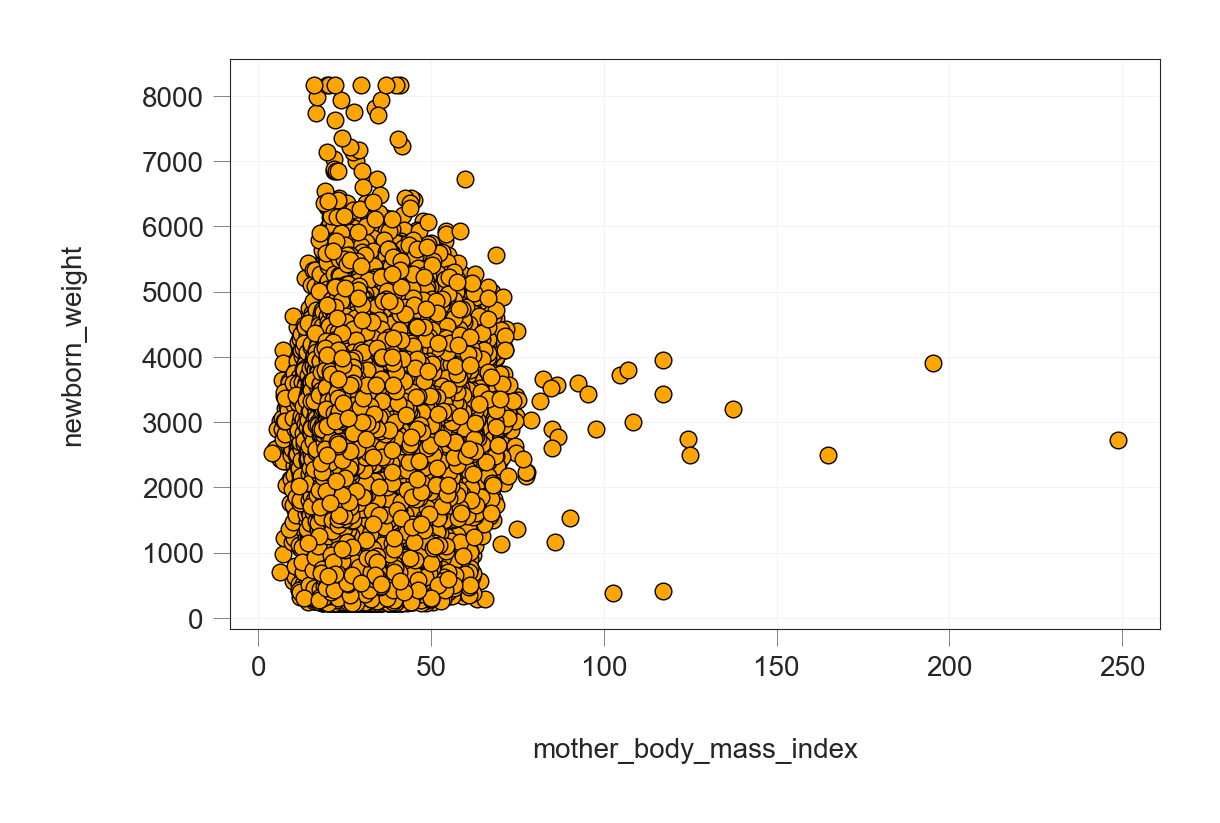

In [12]:
# Plotting 
plt.scatter(x=data_clean['mother_body_mass_index'], y=data_clean['newborn_weight'], 
            color="orange", edgecolors="#000000", linewidths=0.5);
plt.xlabel("mother_body_mass_index"); plt.ylabel("newborn_weight");

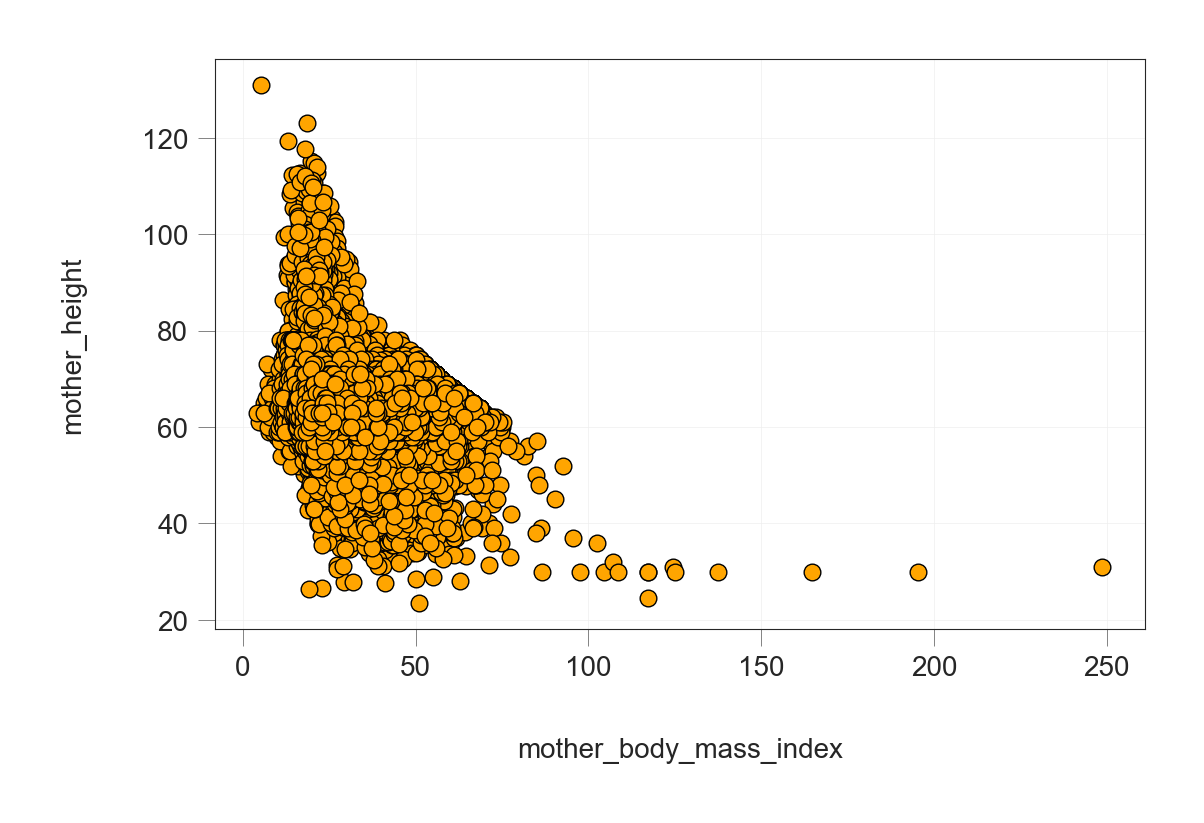

In [13]:
plt.scatter(x=data_clean['mother_body_mass_index'], y=data_clean['mother_height'], 
            color="orange", edgecolors="#000000", linewidths=0.5);
plt.xlabel("mother_body_mass_index"); plt.ylabel("mother_height");

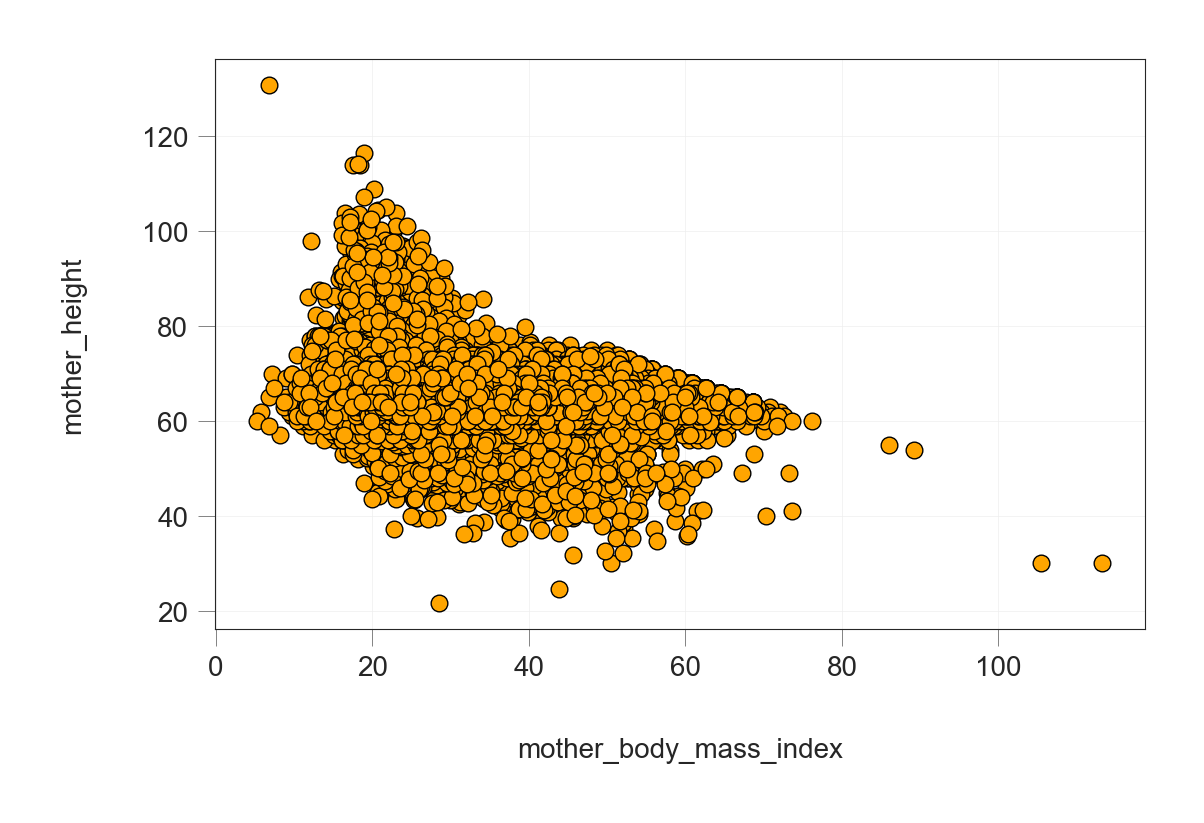

In [14]:
plt.scatter(x=data2_clean['mother_body_mass_index'], y=data2_clean['mother_height'], 
            color="orange", edgecolors="#000000", linewidths=0.5);
plt.xlabel("mother_body_mass_index"); plt.ylabel("mother_height");

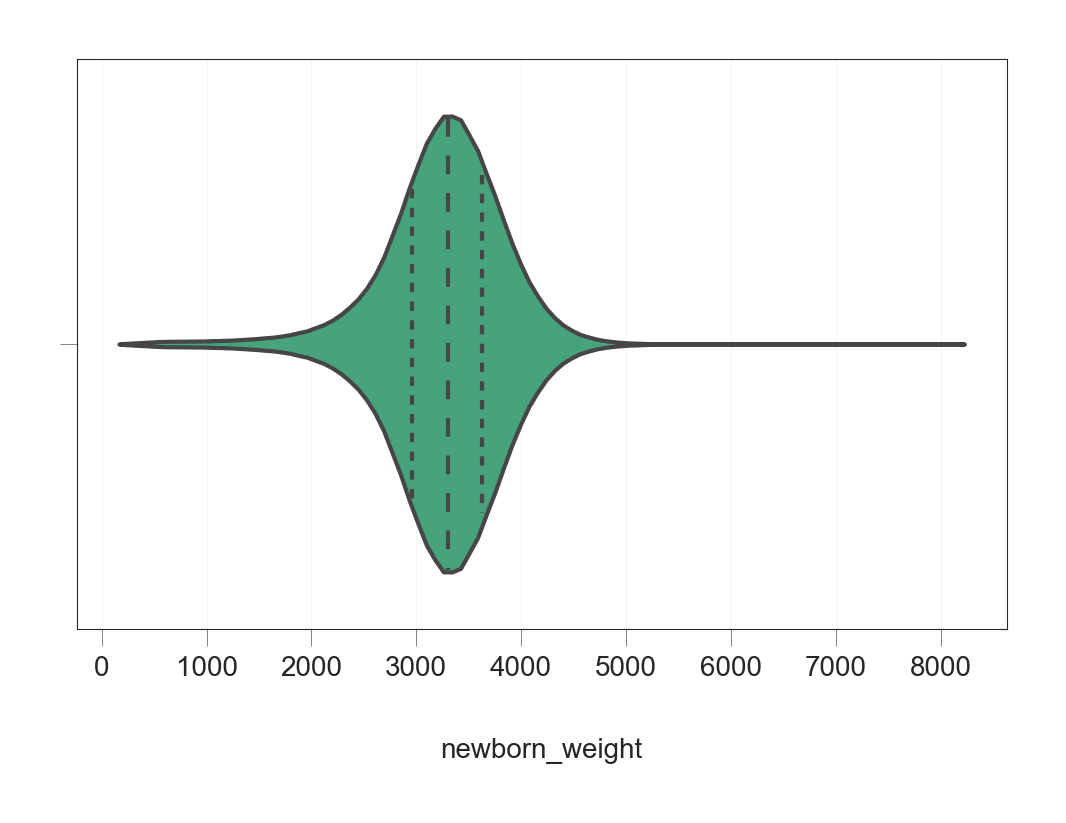

In [15]:
# EDA - Exploratory Data Analysis

## Target variable distribution
sns.violinplot(x = data_clean['newborn_weight'], inner="quartile", color="#36B37E");
# We start by plotting the violin plot for the target variable. 
# The width of the violin represents the frequency. 

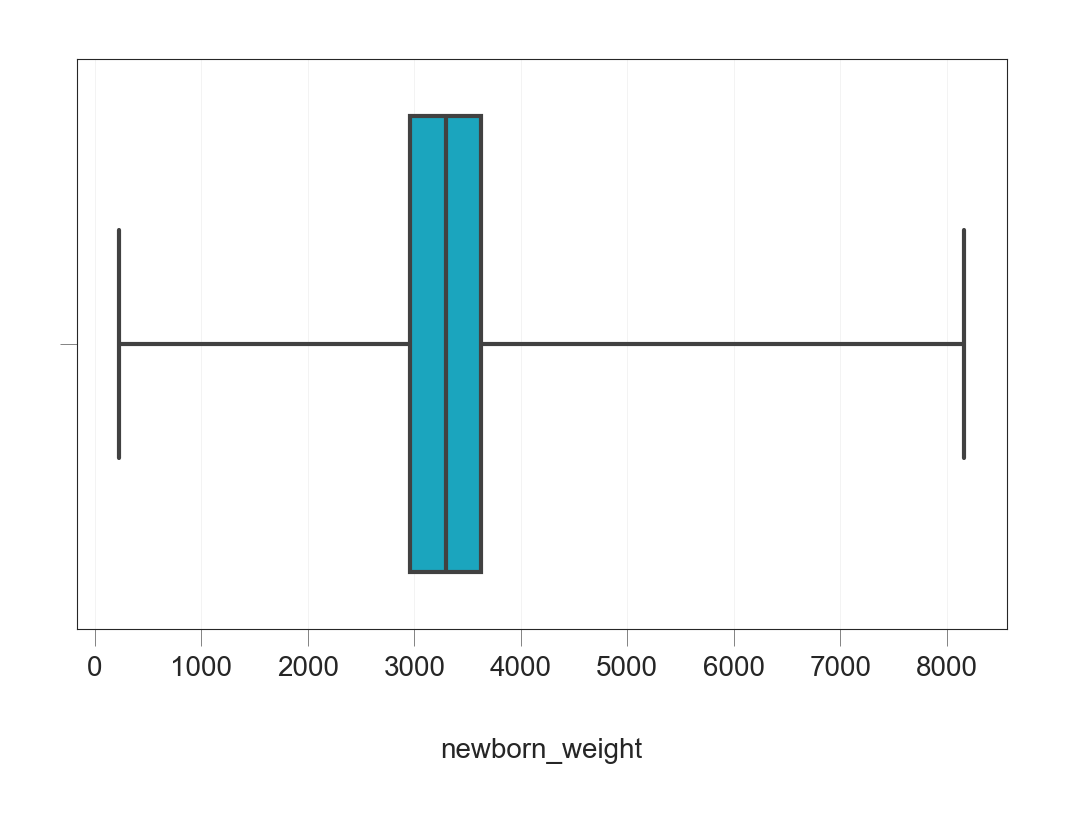

In [16]:
# box plot
sns.boxplot(data_clean['newborn_weight'], whis=10, color="#00B8D9");

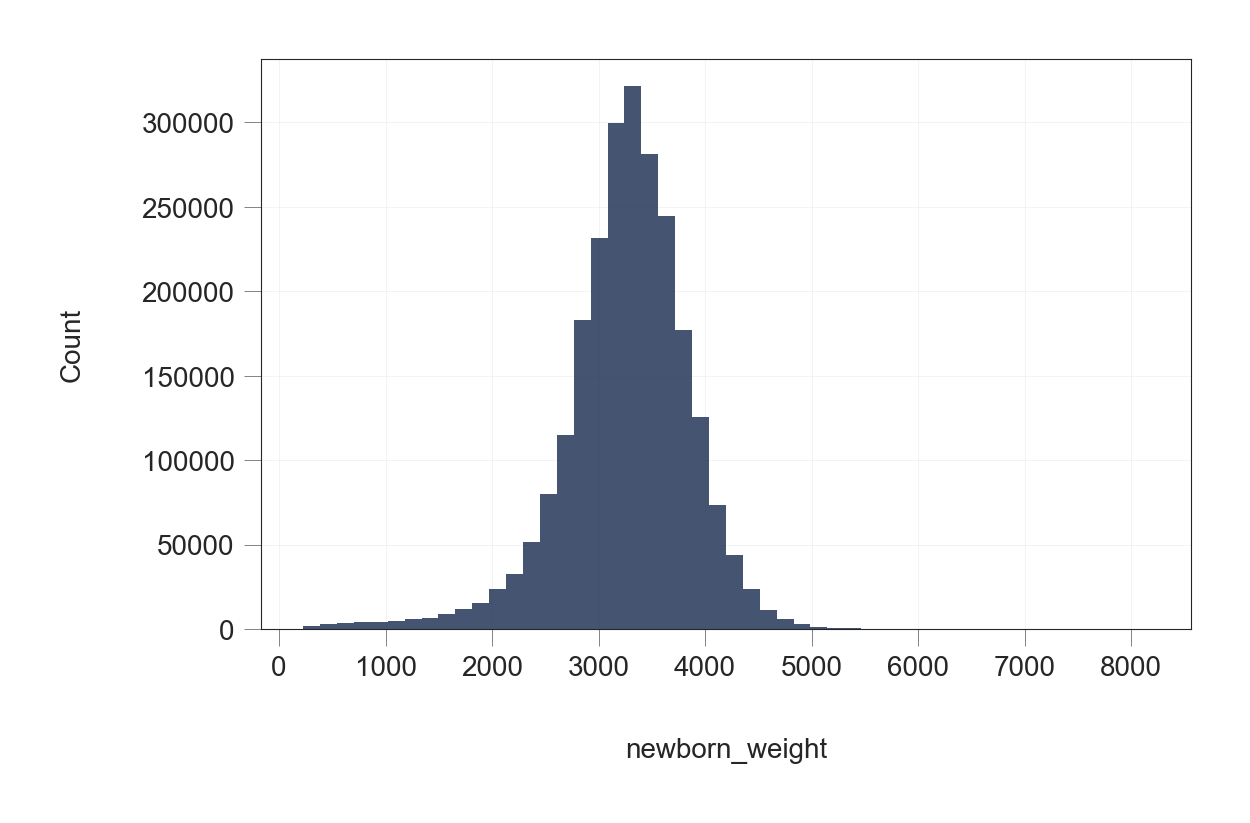

In [17]:
sns.distplot(data_clean['newborn_weight'], kde=False, 
             color="#172B4D", hist_kws={"alpha": 0.8});
plt.ylabel("Count");

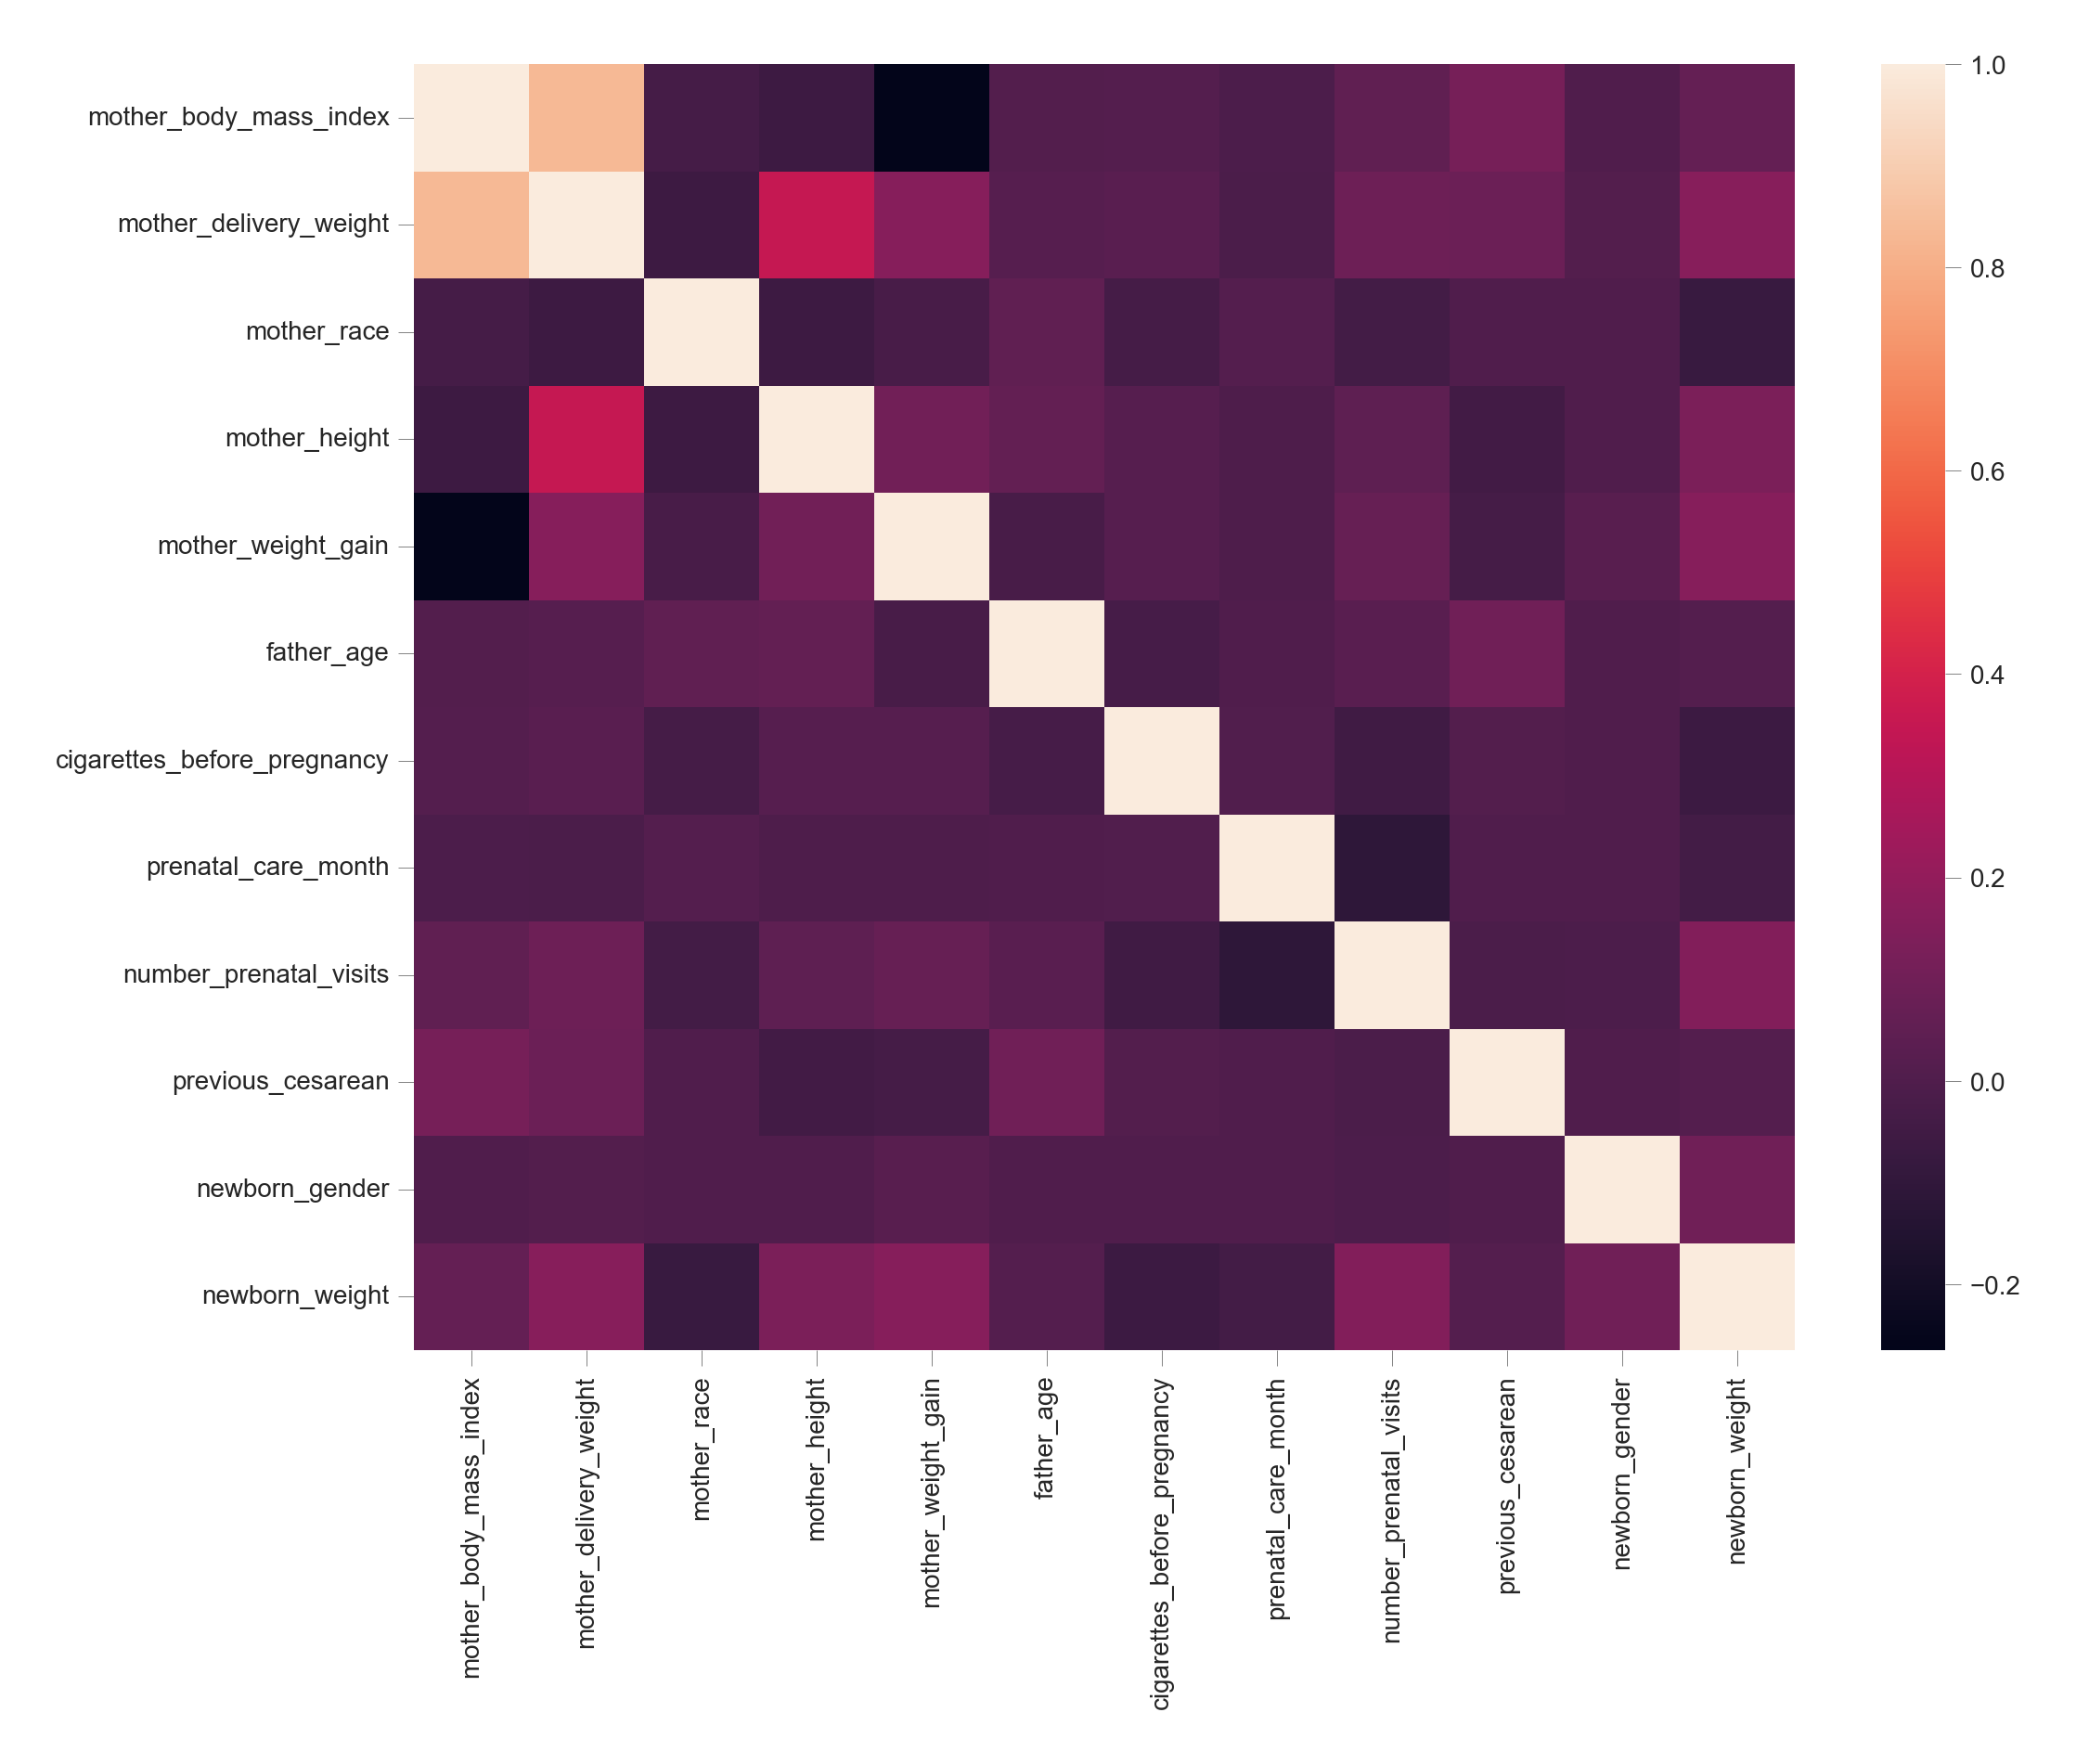

In [18]:
## Correlation
fig, ax = plt.subplots(figsize=(12,9))
sns.heatmap(data_clean.corr(), ax=ax);

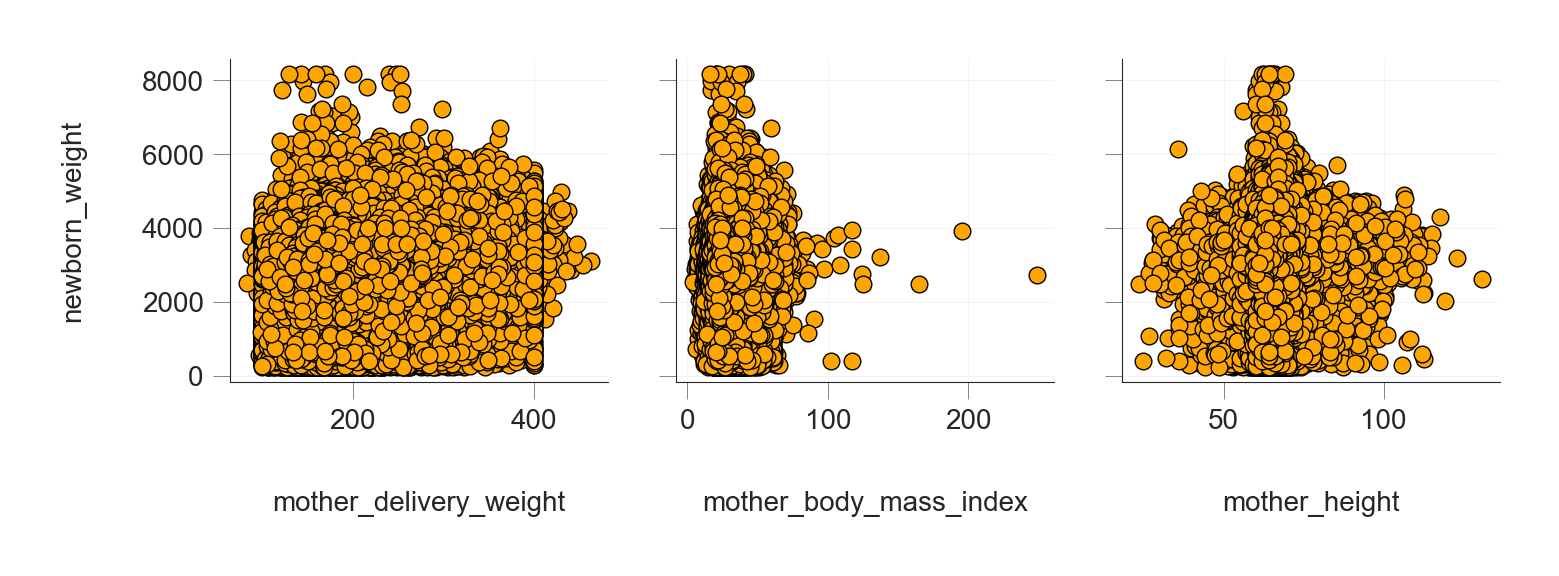

In [19]:
# variables that should be positive correlated but only 2 are, according to the correlation matrix
x_vars = ["mother_delivery_weight", "mother_body_mass_index", "mother_height"]
g = sns.PairGrid(data_clean, y_vars=["newborn_weight"], x_vars=x_vars);
g.map(plt.scatter, color="orange", edgecolors="#000000", linewidths=0.5);

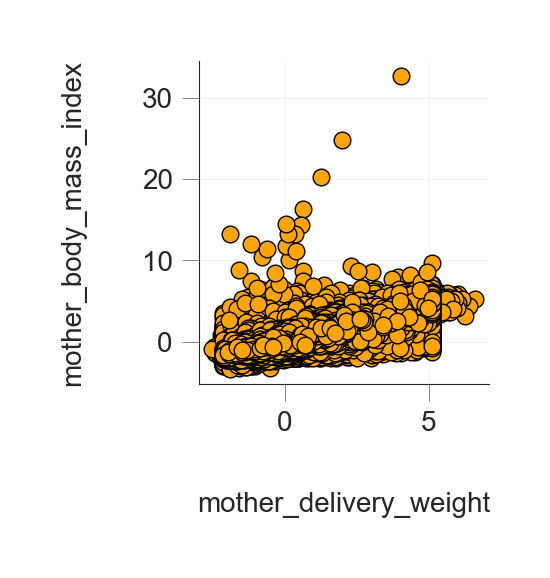

In [39]:
#negative correlation between mother_body_mass_index and mother_weight_gain
x_vars = ["mother_delivery_weight"]
g = sns.PairGrid(data_clean, y_vars= ["mother_body_mass_index"], x_vars=x_vars);
g.map(plt.scatter, color="orange", edgecolors="#000000", linewidths=0.5);

In [26]:
data2_clean.columns

Index(['mother_body_mass_index', 'mother_delivery_weight', 'mother_height',
       'mother_weight_gain', 'father_age', 'cigarettes_before_pregnancy',
       'number_prenatal_visits', 'newborn_gender', 'cesarean_1', 'cesarean_2',
       'cesarean_3', 'care_month_0', 'care_month_1', 'care_month_2',
       'care_month_3', 'care_month_4', 'care_month_5', 'care_month_6',
       'care_month_7', 'care_month_8', 'care_month_9', 'care_month_10',
       'care_month_99', 'mother_race_1', 'mother_race_2', 'mother_race_3',
       'mother_race_4', 'mother_race_5', 'mother_race_6'],
      dtype='object')

In [24]:
## Feature Engineering
### One hot encoding for categorical features
# Perform one-hot encoding
# previous_cesarean' column in data_clean
data_clean = pd.get_dummies(data_clean, columns=['previous_cesarean'], prefix='cesarean')
data2_clean = pd.get_dummies(data2_clean, columns=['previous_cesarean'], prefix='cesarean')

data_clean = pd.get_dummies(data_clean, columns=['prenatal_care_month'], prefix='care_month')
data2_clean = pd.get_dummies(data2_clean, columns=['prenatal_care_month'], prefix='care_month')

data_clean = pd.get_dummies(data_clean, columns=['mother_race'], prefix='mother_race')
data2_clean = pd.get_dummies(data2_clean, columns=['mother_race'], prefix='mother_race')

# Scaling the data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
#training
data_clean.loc[:, data_clean.columns != 'newborn_weight'] = scaler.fit_transform(
    data_clean.loc[:, data_clean.columns != 'newborn_weight'])
#test
data2_clean.loc[:, data2_clean.columns] = scaler.fit_transform(data2_clean.loc[:, data2_clean.columns])


KeyError: "None of [Index(['previous_cesarean'], dtype='object')] are in the [columns]"

In [27]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(
    data_clean.drop('newborn_weight', axis=1), data_clean[['newborn_weight']], 
    test_size=0.25, random_state=3)
y_train = y_train['newborn_weight'].values.ravel()

In [34]:
from tqdm import tqdm
# Create an iterable, for example, a list or range
iterable = range(100)

# Wrap the iterable with tqdm to show the progress bar
for item in tqdm(iterable):
    
    # Random Forest RF
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.model_selection import RandomizedSearchCV
    from sklearn.metrics import make_scorer, mean_absolute_percentage_error

    # Define MAPE scorer
    mape_scorer = make_scorer(mean_absolute_percentage_error, greater_is_better=False)

    parameter_space = {
        "n_estimators": [10],
        "max_depth": [15],
        "max_features": [10],
    }

    clf = RandomizedSearchCV(RandomForestRegressor(random_state=3),
                             parameter_space, cv=3, n_jobs=4,
                             scoring=mape_scorer,
                             n_iter=2, random_state=3)

    clf.fit(x_train, y_train)
    print("Best parameters:")
    print(clf.best_params_)

  1%|▍                                        | 1/100 [00:38<1:03:32, 38.51s/it]

Best parameters:
{'n_estimators': 10, 'max_features': 10, 'max_depth': 15}


  2%|▊                                        | 2/100 [01:16<1:02:06, 38.03s/it]

Best parameters:
{'n_estimators': 10, 'max_features': 10, 'max_depth': 15}


  3%|█▏                                       | 3/100 [01:52<1:00:10, 37.22s/it]

Best parameters:
{'n_estimators': 10, 'max_features': 10, 'max_depth': 15}


  4%|█▋                                         | 4/100 [02:28<58:52, 36.80s/it]

Best parameters:
{'n_estimators': 10, 'max_features': 10, 'max_depth': 15}


  5%|██▏                                        | 5/100 [03:04<57:57, 36.60s/it]

Best parameters:
{'n_estimators': 10, 'max_features': 10, 'max_depth': 15}


  6%|██▌                                        | 6/100 [03:41<57:15, 36.54s/it]

Best parameters:
{'n_estimators': 10, 'max_features': 10, 'max_depth': 15}


  7%|███                                        | 7/100 [04:17<56:41, 36.58s/it]

Best parameters:
{'n_estimators': 10, 'max_features': 10, 'max_depth': 15}


  8%|███▍                                       | 8/100 [04:54<56:02, 36.55s/it]

Best parameters:
{'n_estimators': 10, 'max_features': 10, 'max_depth': 15}


  9%|███▊                                       | 9/100 [05:30<55:24, 36.54s/it]

Best parameters:
{'n_estimators': 10, 'max_features': 10, 'max_depth': 15}


 10%|████▏                                     | 10/100 [06:07<54:45, 36.51s/it]

Best parameters:
{'n_estimators': 10, 'max_features': 10, 'max_depth': 15}


 11%|████▌                                     | 11/100 [06:43<54:06, 36.48s/it]

Best parameters:
{'n_estimators': 10, 'max_features': 10, 'max_depth': 15}


 12%|█████                                     | 12/100 [07:20<53:33, 36.52s/it]

Best parameters:
{'n_estimators': 10, 'max_features': 10, 'max_depth': 15}


 13%|█████▍                                    | 13/100 [07:56<52:52, 36.47s/it]

Best parameters:
{'n_estimators': 10, 'max_features': 10, 'max_depth': 15}


 14%|█████▉                                    | 14/100 [08:32<52:09, 36.39s/it]

Best parameters:
{'n_estimators': 10, 'max_features': 10, 'max_depth': 15}


 15%|██████▎                                   | 15/100 [09:09<51:27, 36.32s/it]

Best parameters:
{'n_estimators': 10, 'max_features': 10, 'max_depth': 15}


 16%|██████▋                                   | 16/100 [09:45<50:48, 36.29s/it]

Best parameters:
{'n_estimators': 10, 'max_features': 10, 'max_depth': 15}


 17%|███████▏                                  | 17/100 [10:21<50:09, 36.25s/it]

Best parameters:
{'n_estimators': 10, 'max_features': 10, 'max_depth': 15}


 18%|███████▌                                  | 18/100 [10:57<49:29, 36.22s/it]

Best parameters:
{'n_estimators': 10, 'max_features': 10, 'max_depth': 15}


 19%|███████▉                                  | 19/100 [11:33<48:49, 36.17s/it]

Best parameters:
{'n_estimators': 10, 'max_features': 10, 'max_depth': 15}


 20%|████████▍                                 | 20/100 [12:09<48:12, 36.15s/it]

Best parameters:
{'n_estimators': 10, 'max_features': 10, 'max_depth': 15}


 21%|████████▊                                 | 21/100 [12:46<47:36, 36.16s/it]

Best parameters:
{'n_estimators': 10, 'max_features': 10, 'max_depth': 15}


 22%|█████████▏                                | 22/100 [13:22<46:58, 36.14s/it]

Best parameters:
{'n_estimators': 10, 'max_features': 10, 'max_depth': 15}


 23%|█████████▋                                | 23/100 [13:58<46:22, 36.14s/it]

Best parameters:
{'n_estimators': 10, 'max_features': 10, 'max_depth': 15}


 24%|██████████                                | 24/100 [14:34<45:44, 36.11s/it]

Best parameters:
{'n_estimators': 10, 'max_features': 10, 'max_depth': 15}


 25%|██████████▌                               | 25/100 [15:10<45:07, 36.10s/it]

Best parameters:
{'n_estimators': 10, 'max_features': 10, 'max_depth': 15}


 26%|██████████▉                               | 26/100 [15:46<44:32, 36.11s/it]

Best parameters:
{'n_estimators': 10, 'max_features': 10, 'max_depth': 15}


 27%|███████████▎                              | 27/100 [16:22<43:52, 36.06s/it]

Best parameters:
{'n_estimators': 10, 'max_features': 10, 'max_depth': 15}


 28%|███████████▊                              | 28/100 [16:58<43:16, 36.06s/it]

Best parameters:
{'n_estimators': 10, 'max_features': 10, 'max_depth': 15}


 29%|████████████▏                             | 29/100 [17:34<42:38, 36.04s/it]

Best parameters:
{'n_estimators': 10, 'max_features': 10, 'max_depth': 15}


 30%|████████████▌                             | 30/100 [18:10<42:02, 36.03s/it]

Best parameters:
{'n_estimators': 10, 'max_features': 10, 'max_depth': 15}


 31%|█████████████                             | 31/100 [18:46<41:27, 36.05s/it]

Best parameters:
{'n_estimators': 10, 'max_features': 10, 'max_depth': 15}


 32%|█████████████▍                            | 32/100 [19:22<40:51, 36.04s/it]

Best parameters:
{'n_estimators': 10, 'max_features': 10, 'max_depth': 15}


 33%|█████████████▊                            | 33/100 [19:58<40:13, 36.03s/it]

Best parameters:
{'n_estimators': 10, 'max_features': 10, 'max_depth': 15}


 34%|██████████████▎                           | 34/100 [20:34<39:37, 36.02s/it]

Best parameters:
{'n_estimators': 10, 'max_features': 10, 'max_depth': 15}


 35%|██████████████▋                           | 35/100 [21:10<39:02, 36.04s/it]

Best parameters:
{'n_estimators': 10, 'max_features': 10, 'max_depth': 15}


 36%|███████████████                           | 36/100 [21:46<38:26, 36.04s/it]

Best parameters:
{'n_estimators': 10, 'max_features': 10, 'max_depth': 15}


 37%|███████████████▌                          | 37/100 [22:22<37:52, 36.06s/it]

Best parameters:
{'n_estimators': 10, 'max_features': 10, 'max_depth': 15}


 38%|███████████████▉                          | 38/100 [22:58<37:16, 36.07s/it]

Best parameters:
{'n_estimators': 10, 'max_features': 10, 'max_depth': 15}


 39%|████████████████▍                         | 39/100 [23:35<36:39, 36.06s/it]

Best parameters:
{'n_estimators': 10, 'max_features': 10, 'max_depth': 15}


 40%|████████████████▊                         | 40/100 [24:11<36:04, 36.08s/it]

Best parameters:
{'n_estimators': 10, 'max_features': 10, 'max_depth': 15}


 41%|█████████████████▏                        | 41/100 [24:47<35:28, 36.07s/it]

Best parameters:
{'n_estimators': 10, 'max_features': 10, 'max_depth': 15}


 42%|█████████████████▋                        | 42/100 [25:23<34:51, 36.06s/it]

Best parameters:
{'n_estimators': 10, 'max_features': 10, 'max_depth': 15}


 43%|██████████████████                        | 43/100 [25:59<34:15, 36.07s/it]

Best parameters:
{'n_estimators': 10, 'max_features': 10, 'max_depth': 15}


 44%|██████████████████▍                       | 44/100 [26:35<33:39, 36.07s/it]

Best parameters:
{'n_estimators': 10, 'max_features': 10, 'max_depth': 15}


 45%|██████████████████▉                       | 45/100 [27:11<33:03, 36.07s/it]

Best parameters:
{'n_estimators': 10, 'max_features': 10, 'max_depth': 15}


 46%|███████████████████▎                      | 46/100 [27:47<32:26, 36.05s/it]

Best parameters:
{'n_estimators': 10, 'max_features': 10, 'max_depth': 15}


 47%|███████████████████▋                      | 47/100 [28:23<31:53, 36.10s/it]

Best parameters:
{'n_estimators': 10, 'max_features': 10, 'max_depth': 15}


 48%|████████████████████▏                     | 48/100 [28:59<31:15, 36.06s/it]

Best parameters:
{'n_estimators': 10, 'max_features': 10, 'max_depth': 15}


 49%|████████████████████▌                     | 49/100 [29:35<30:39, 36.08s/it]

Best parameters:
{'n_estimators': 10, 'max_features': 10, 'max_depth': 15}


 50%|█████████████████████                     | 50/100 [30:11<30:03, 36.07s/it]

Best parameters:
{'n_estimators': 10, 'max_features': 10, 'max_depth': 15}


 51%|█████████████████████▍                    | 51/100 [30:47<29:25, 36.03s/it]

Best parameters:
{'n_estimators': 10, 'max_features': 10, 'max_depth': 15}


 52%|█████████████████████▊                    | 52/100 [31:23<28:50, 36.04s/it]

Best parameters:
{'n_estimators': 10, 'max_features': 10, 'max_depth': 15}


 53%|██████████████████████▎                   | 53/100 [31:59<28:13, 36.04s/it]

Best parameters:
{'n_estimators': 10, 'max_features': 10, 'max_depth': 15}


 54%|██████████████████████▋                   | 54/100 [32:35<27:38, 36.05s/it]

Best parameters:
{'n_estimators': 10, 'max_features': 10, 'max_depth': 15}


 55%|███████████████████████                   | 55/100 [33:11<27:02, 36.05s/it]

Best parameters:
{'n_estimators': 10, 'max_features': 10, 'max_depth': 15}


 56%|███████████████████████▌                  | 56/100 [33:48<26:25, 36.04s/it]

Best parameters:
{'n_estimators': 10, 'max_features': 10, 'max_depth': 15}


 57%|███████████████████████▉                  | 57/100 [34:24<25:50, 36.05s/it]

Best parameters:
{'n_estimators': 10, 'max_features': 10, 'max_depth': 15}


 58%|████████████████████████▎                 | 58/100 [35:00<25:13, 36.04s/it]

Best parameters:
{'n_estimators': 10, 'max_features': 10, 'max_depth': 15}


 59%|████████████████████████▊                 | 59/100 [35:36<24:37, 36.04s/it]

Best parameters:
{'n_estimators': 10, 'max_features': 10, 'max_depth': 15}


 60%|█████████████████████████▏                | 60/100 [36:12<24:01, 36.04s/it]

Best parameters:
{'n_estimators': 10, 'max_features': 10, 'max_depth': 15}


 61%|█████████████████████████▌                | 61/100 [36:48<23:25, 36.03s/it]

Best parameters:
{'n_estimators': 10, 'max_features': 10, 'max_depth': 15}


 62%|██████████████████████████                | 62/100 [37:24<22:50, 36.05s/it]

Best parameters:
{'n_estimators': 10, 'max_features': 10, 'max_depth': 15}


 63%|██████████████████████████▍               | 63/100 [38:00<22:13, 36.05s/it]

Best parameters:
{'n_estimators': 10, 'max_features': 10, 'max_depth': 15}


 64%|██████████████████████████▉               | 64/100 [38:36<21:37, 36.05s/it]

Best parameters:
{'n_estimators': 10, 'max_features': 10, 'max_depth': 15}


 65%|███████████████████████████▎              | 65/100 [39:12<21:01, 36.05s/it]

Best parameters:
{'n_estimators': 10, 'max_features': 10, 'max_depth': 15}


 66%|███████████████████████████▋              | 66/100 [39:48<20:24, 36.02s/it]

Best parameters:
{'n_estimators': 10, 'max_features': 10, 'max_depth': 15}


 67%|████████████████████████████▏             | 67/100 [40:24<19:49, 36.04s/it]

Best parameters:
{'n_estimators': 10, 'max_features': 10, 'max_depth': 15}


 68%|████████████████████████████▌             | 68/100 [41:00<19:13, 36.04s/it]

Best parameters:
{'n_estimators': 10, 'max_features': 10, 'max_depth': 15}


 69%|████████████████████████████▉             | 69/100 [41:36<18:36, 36.02s/it]

Best parameters:
{'n_estimators': 10, 'max_features': 10, 'max_depth': 15}


 70%|█████████████████████████████▍            | 70/100 [42:12<18:00, 36.02s/it]

Best parameters:
{'n_estimators': 10, 'max_features': 10, 'max_depth': 15}


 71%|█████████████████████████████▊            | 71/100 [42:48<17:23, 36.00s/it]

Best parameters:
{'n_estimators': 10, 'max_features': 10, 'max_depth': 15}


 72%|██████████████████████████████▏           | 72/100 [43:24<16:48, 36.01s/it]

Best parameters:
{'n_estimators': 10, 'max_features': 10, 'max_depth': 15}


 73%|██████████████████████████████▋           | 73/100 [44:00<16:12, 36.02s/it]

Best parameters:
{'n_estimators': 10, 'max_features': 10, 'max_depth': 15}


 74%|███████████████████████████████           | 74/100 [44:36<15:36, 36.01s/it]

Best parameters:
{'n_estimators': 10, 'max_features': 10, 'max_depth': 15}


 75%|███████████████████████████████▌          | 75/100 [45:12<15:00, 36.00s/it]

Best parameters:
{'n_estimators': 10, 'max_features': 10, 'max_depth': 15}


 76%|███████████████████████████████▉          | 76/100 [45:48<14:23, 35.98s/it]

Best parameters:
{'n_estimators': 10, 'max_features': 10, 'max_depth': 15}


 77%|████████████████████████████████▎         | 77/100 [46:24<13:47, 35.98s/it]

Best parameters:
{'n_estimators': 10, 'max_features': 10, 'max_depth': 15}


 78%|████████████████████████████████▊         | 78/100 [47:00<13:11, 35.99s/it]

Best parameters:
{'n_estimators': 10, 'max_features': 10, 'max_depth': 15}


 79%|█████████████████████████████████▏        | 79/100 [47:36<12:35, 35.99s/it]

Best parameters:
{'n_estimators': 10, 'max_features': 10, 'max_depth': 15}


 80%|█████████████████████████████████▌        | 80/100 [48:12<12:01, 36.05s/it]

Best parameters:
{'n_estimators': 10, 'max_features': 10, 'max_depth': 15}


 81%|██████████████████████████████████        | 81/100 [48:49<11:29, 36.29s/it]

Best parameters:
{'n_estimators': 10, 'max_features': 10, 'max_depth': 15}


 82%|██████████████████████████████████▍       | 82/100 [49:25<10:52, 36.25s/it]

Best parameters:
{'n_estimators': 10, 'max_features': 10, 'max_depth': 15}


 83%|██████████████████████████████████▊       | 83/100 [50:01<10:16, 36.25s/it]

Best parameters:
{'n_estimators': 10, 'max_features': 10, 'max_depth': 15}


 84%|███████████████████████████████████▎      | 84/100 [50:37<09:39, 36.20s/it]

Best parameters:
{'n_estimators': 10, 'max_features': 10, 'max_depth': 15}


 85%|███████████████████████████████████▋      | 85/100 [51:13<09:02, 36.15s/it]

Best parameters:
{'n_estimators': 10, 'max_features': 10, 'max_depth': 15}


 86%|████████████████████████████████████      | 86/100 [51:49<08:25, 36.11s/it]

Best parameters:
{'n_estimators': 10, 'max_features': 10, 'max_depth': 15}


 87%|████████████████████████████████████▌     | 87/100 [52:26<07:49, 36.09s/it]

Best parameters:
{'n_estimators': 10, 'max_features': 10, 'max_depth': 15}


 88%|████████████████████████████████████▉     | 88/100 [53:02<07:12, 36.07s/it]

Best parameters:
{'n_estimators': 10, 'max_features': 10, 'max_depth': 15}


 89%|█████████████████████████████████████▍    | 89/100 [53:38<06:36, 36.04s/it]

Best parameters:
{'n_estimators': 10, 'max_features': 10, 'max_depth': 15}


 90%|█████████████████████████████████████▊    | 90/100 [54:13<06:00, 36.02s/it]

Best parameters:
{'n_estimators': 10, 'max_features': 10, 'max_depth': 15}


 91%|██████████████████████████████████████▏   | 91/100 [54:49<05:23, 36.00s/it]

Best parameters:
{'n_estimators': 10, 'max_features': 10, 'max_depth': 15}


 92%|██████████████████████████████████████▋   | 92/100 [55:26<04:48, 36.03s/it]

Best parameters:
{'n_estimators': 10, 'max_features': 10, 'max_depth': 15}


 93%|███████████████████████████████████████   | 93/100 [56:02<04:12, 36.03s/it]

Best parameters:
{'n_estimators': 10, 'max_features': 10, 'max_depth': 15}


 94%|███████████████████████████████████████▍  | 94/100 [56:38<03:36, 36.02s/it]

Best parameters:
{'n_estimators': 10, 'max_features': 10, 'max_depth': 15}


 95%|███████████████████████████████████████▉  | 95/100 [57:14<03:00, 36.01s/it]

Best parameters:
{'n_estimators': 10, 'max_features': 10, 'max_depth': 15}


 96%|████████████████████████████████████████▎ | 96/100 [57:50<02:24, 36.03s/it]

Best parameters:
{'n_estimators': 10, 'max_features': 10, 'max_depth': 15}


 97%|████████████████████████████████████████▋ | 97/100 [58:26<01:48, 36.02s/it]

Best parameters:
{'n_estimators': 10, 'max_features': 10, 'max_depth': 15}


 98%|█████████████████████████████████████████▏| 98/100 [59:02<01:11, 36.00s/it]

Best parameters:
{'n_estimators': 10, 'max_features': 10, 'max_depth': 15}


 99%|█████████████████████████████████████████▌| 99/100 [59:38<00:36, 36.02s/it]

Best parameters:
{'n_estimators': 10, 'max_features': 10, 'max_depth': 15}


100%|███████████████████████████████████████| 100/100 [1:00:14<00:00, 36.14s/it]

Best parameters:
{'n_estimators': 10, 'max_features': 10, 'max_depth': 15}


In [35]:
# RF with the parameters found:
rf_model = RandomForestRegressor(**clf.best_params_)
# training RF
rf_model.fit(x_train, y_train);
# testing RF
y_pred_rf = rf_model.predict(x_test)

# MAPE RF
rf_mape = mean_absolute_percentage_error(y_test, y_pred_rf)
print("Random Forest MAPE =", rf_mape)

Random Forest MAPE = 0.1577357832231009


In [36]:
# real test on test set
y_prediction = rf_model.predict(data2_clean)

In [37]:
# Assuming y_pred is a NumPy array or a pandas Series
predictions = pd.Series(y_prediction, name='Predicted')
# Create a DataFrame with the predicted values
predictions_df = pd.DataFrame(predictions)

# Save the DataFrame to a CSV file
predictions_df.to_csv('predictions_regressionrf.csv', index=False)

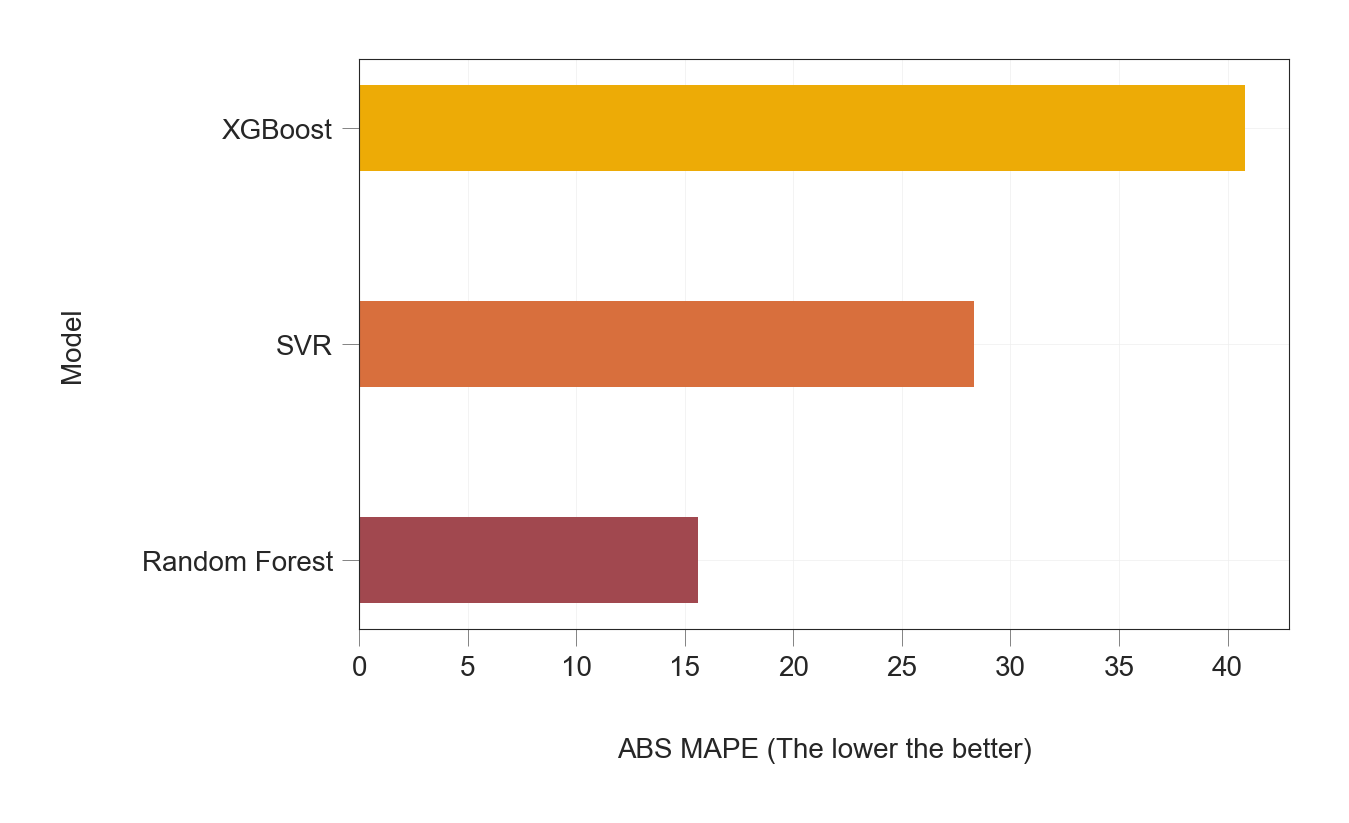

In [41]:
# Graph to visualize the contents
x = ['Random Forest', 'SVR', 'XGBoost']
y = [15.8, 28.3 , 40.8]
colors = ["#a1484f", "#d86f3d", "#edab06"]
fig, ax = plt.subplots()
plt.barh(y=range(len(x)), tick_label=x, width=y, height=0.4, color=colors);
ax.set(xlabel="ABS MAPE (The lower the better)", ylabel="Model");